In [59]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import serial
from math import *

### Create signal

[3.12389769e-05 1.24955908e-04 1.87433862e-04 1.24955908e-04
 3.12389769e-05]
[ 1.         -3.58973389  4.85127588 -2.92405266  0.66301048]


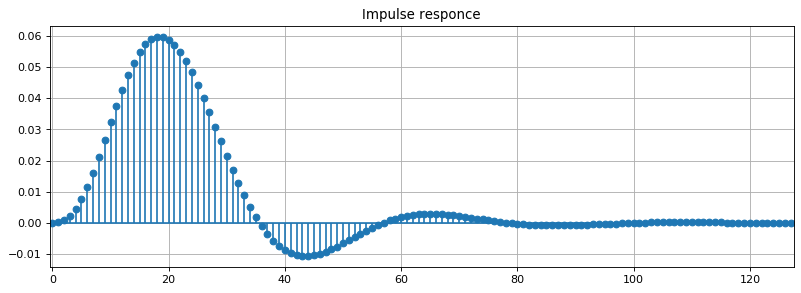

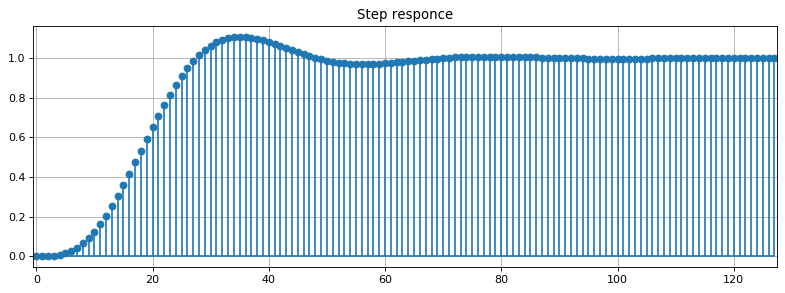

In [60]:
N = 128

b, a = signal.butter(4, 0.05)

imp = np.zeros(N).astype(np.int32)
imp[0] = 1
imp_response = signal.lfilter(b,a,imp)

plt.figure(figsize=(12, 4), dpi=80)
plt.title('Impulse responce')
plt.stem(imp_response, use_line_collection=True, basefmt='C0')
#plt.plot(imp_response)
plt.xlim([-0.5, N-0.5])
plt.grid(True)

step = np.ones(N).astype(np.int32)
step_response = signal.lfilter(b,a,step)

plt.figure(figsize=(12, 4), dpi=80)
plt.title('Step responce')
plt.stem(step_response, use_line_collection=True, basefmt='C0')
#plt.plot(step_response)
plt.xlim([-0.5, N-0.5])
plt.grid(True)

print(b)
print(a)

### Convert coefficients to fixed point and save to file

In [61]:
FW = 28 # floating word length
INPUT_WIDTH = 32 # input data width

HEX_LEN = INPUT_WIDTH // 4 if INPUT_WIDTH % 4 == 0 else INPUT_WIDTH // 4 + 1 # hex number length 

b_fix = np.around(b*(2**FW)).astype(np.int64) # convert float to fixed
# convert negative values to two's comp and shrink to INPUT_WIDTH size
b_fix[b_fix < 0] = (b_fix[b_fix < 0] + 2**(INPUT_WIDTH)) & (2**32 - 1) >> (32 - INPUT_WIDTH)

a_fix = np.around(a*(2**FW)).astype(np.int64)
a_fix[a_fix < 0] = (a_fix[a_fix < 0] + 2**(INPUT_WIDTH)) & (2**32 - 1) >> (32 - INPUT_WIDTH)

np.savetxt("iir_coefs_b.mem", b_fix, f'%.{HEX_LEN}x')
np.savetxt("iir_coefs_a.mem", a_fix, f'%.{HEX_LEN}x')

### Convert signal to fixed point and save to file

In [62]:
sig = imp

sig_fix = np.around(sig*(2**FW)).astype(np.int32)
sig_fix.tofile('./iir_tb_input.bin')

### Get TB output

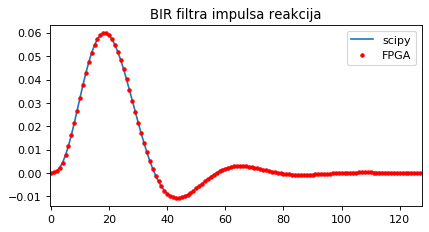

In [64]:
iir_tb_out_fix = np.fromfile('./iir_tb_output.bin', dtype=np.int32)

iir_tb_out = iir_tb_out_fix.copy()
#iir_tb_out[iir_tb_out >= (1 << 31)] -= (1 << 32)
iir_tb_out = iir_tb_out/(2**(FW))

plt.figure(figsize=(6, 3), dpi=80)
plt.title('BIR filtra impulsa reakcija')
#plt.stem(imp_response, use_line_collection=True, basefmt='C0')
#plt.stem(iir_tb_out, linefmt='r', markerfmt='r.',use_line_collection=True, basefmt='C0')
plt.plot(imp_response)
plt.plot(iir_tb_out, 'r.')
plt.xlim([-0.5, N-0.5])
plt.legend(('scipy', 'FPGA'), loc='best')
#plt.minorticks_on()
#plt.grid(True, which='both', color='0.90')

plt.savefig('iir_imp.png')

### FPGA serial communication

In [68]:
n_bytes = int(HEX_LEN / 2)
samples = [(i.item()).to_bytes(n_bytes, byteorder='big', signed=True) for i in sig_fix]

fpga_bytes_out = b''
fir_fpga_out_fix = list()

with serial.Serial('/dev/ttyUSB0', 115200, timeout = 2) as ser:
    for i in samples:
        ser.write(i)
        for i in range(4):
            s = ser.read()
            fpga_bytes_out = fpga_bytes_out + s

        fir_fpga_out_fix.append(int.from_bytes(fpga_bytes_out, byteorder='big', signed=True))
        fpga_bytes_out = b''

print("done!")
print(fir_fpga_out_fix)

done!
[8386, 63646, 238103, 604026, 1202119, 2039018, 3096060, 4336776, 5713209, 7171155, 8654426, 10108230, 11481764, 12730111, 13815527, 14708204, 15386590, 15837339, 16054963, 16041249, 15804502, 15358667, 14722375, 13917957, 12970459, 11906689, 10754320, 9541067, 8293953, 7038674, 5799067, 4596685, 3450477, 2376569, 1388141, 495390, -294427, -976881, -1550202, -2015063, -2374326, -2632762, -2796755, -2873998, -2873190, -2803741, -2675491, -2498448, -2282550, -2037454, -1772353, -1495824, -1215705, -939003, -671831, -419371, -185862, 25388, 211972, 372335, 505713, 612060, 691966, 746571, 777475, 786649, 776347, 749021, 707241, 653622, 590758, 521164, 447226, 371161, 294984, 220484, 149208, 82453, 21264, -33562, -81466, -122113, -155375, -181310, -200140, -212227, -218049, -218176, -213246, -203943, -190976, -175059, -156894, -137156, -116481, -95455, -74606, -54398, -35228, -17424, -1245, 13117, 25534, 35937, 44312, 50694, 55160, 57823, 58825, 58330, 56518, 53579, 49708, 45100, 3994

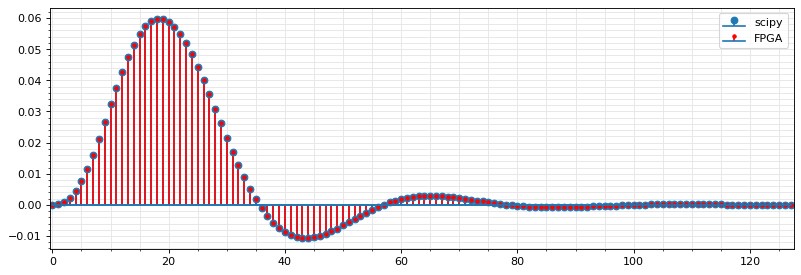

In [69]:
fir_fpga_out_fix = np.array(fir_fpga_out_fix, dtype=np.int32)
fir_fpga_out = fir_fpga_out_fix/(2**(FW))

plt.figure(figsize=(12, 4), dpi=80)
plt.stem(imp_response, use_line_collection=True, basefmt='C0')
plt.stem(fir_fpga_out, linefmt='r', markerfmt='r.',use_line_collection=True, basefmt='C0')
#plt.plot(imp_response)
plt.xlim([-0.5, N-0.5])
plt.legend(('scipy', 'FPGA'), loc='best')
plt.minorticks_on()
plt.grid(True, which='both', color='0.90')